## Use GCPSReader

Within `titiler-image` we developed a `Reader` that allow passing external GCPS (Ground Control Points) and Cutline in order to virtually georeference and mask a dataset

This notebook will show how it works

In [63]:
from io import BytesIO

from titiler.image.reader import GCPSReader
from rio_tiler.io import ImageReader

from IPython.display import Image

In [64]:
# Non-Geo COG - RGB + Internal Mask
image_path = "https://raw.githubusercontent.com/developmentseed/titiler-image/main/tests/fixtures/boston.tif"

# GeoJSON file 
gcps_path = "https://raw.githubusercontent.com/developmentseed/titiler-image/main/tests/fixtures/boston.geojson"

#### Open File and Show a preview

In [65]:
# ImageReader is a rio-tiler reader for `non-geo` images
with ImageReader(image_path) as src:
    print(src.info().json())

{"bounds": [0, 5352, 7696, 0], "minzoom": 0, "maxzoom": 5, "band_metadata": [["b1", {}], ["b2", {}], ["b3", {}]], "band_descriptions": [["b1", ""], ["b2", ""], ["b3", ""]], "dtype": "uint8", "nodata_type": "Mask", "colorinterp": ["red", "green", "blue"], "scale": null, "offset": null, "colormap": null, "count": 3, "width": 7696, "overviews": [2, 4, 8, 16], "height": 5352, "driver": "GTiff"}


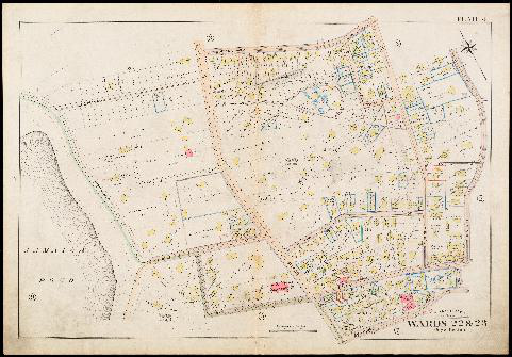

In [81]:
with ImageReader(image_path) as src:
    im = src.preview(max_size=512)

Image(im.render())

## Ground Control Points

Ref: https://gdal.org/user/raster_data_model.html#gcps

For this example we use a geojson file which follow the IIIF Georef extension format (proposal, https://github.com/allmaps/iiif-api/blob/georef/source/extension/georef/index.md#35-the-resourcecoords-property)

In [67]:
import httpx
import json
from rasterio.control import GroundControlPoint

r = httpx.get(gcps_path)
gcps_geojson = r.json()

print("GCPS FeatureCollection")
print(gcps_geojson)
print()
print("Example of one point")
p = gcps_geojson["features"][0]
print(p)
print()
print(f"Geo Coordinates (lon, lat): {p['geometry']['coordinates']}")
print(f"Image Coordinates (x, y): {p['properties']['resourceCoords']}")

GCPS FeatureCollection
{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'resourceCoords': [3011, 1187]}, 'geometry': {'type': 'Point', 'coordinates': [-71.11313846819577, 42.31750853403672]}}, {'type': 'Feature', 'properties': {'resourceCoords': [5241, 5053]}, 'geometry': {'type': 'Point', 'coordinates': [-71.11414794574848, 42.31229871703916]}}, {'type': 'Feature', 'properties': {'resourceCoords': [5615, 351]}, 'geometry': {'type': 'Point', 'coordinates': [-71.10904954715107, 42.31648965975142]}}, {'type': 'Feature', 'properties': {'resourceCoords': [7012, 3894]}, 'geometry': {'type': 'Point', 'coordinates': [-71.11068726339353, 42.312086619361835]}}]}

Example of one point
{'type': 'Feature', 'properties': {'resourceCoords': [3011, 1187]}, 'geometry': {'type': 'Point', 'coordinates': [-71.11313846819577, 42.31750853403672]}}

Geo Coordinates (lon, lat): [-71.11313846819577, 42.31750853403672]
Image Coordinates (x, y): [3011, 1187]


##### Create Rasterio GCPS from the GeoJSON 

In [83]:
gcps = [
    # GroundControlPoint(row, col, x, y, z)
    # https://github.com/allmaps/iiif-api/blob/georef/source/extension/georef/index.md#35-the-resourcecoords-property
    GroundControlPoint(
        f["properties"]["resourceCoords"][1], # row = y
        f["properties"]["resourceCoords"][0], # col = x
        *f["geometry"]["coordinates"],  # lon, lat, z
    )
    for f in gcps_geojson["features"]
]

print(gcps[0])

GroundControlPoint(row=1187, col=3011, x=-71.11313846819577, y=42.31750853403672, id='54ce76e2-f7f5-40d6-b716-374b3e4269fa')


### Show GCPS on the image

ERROR 1: JPEGLib:Improper call to JPEG library in state 205
ERROR 1: JPEGSetupDecode:Bogus JPEGTables field


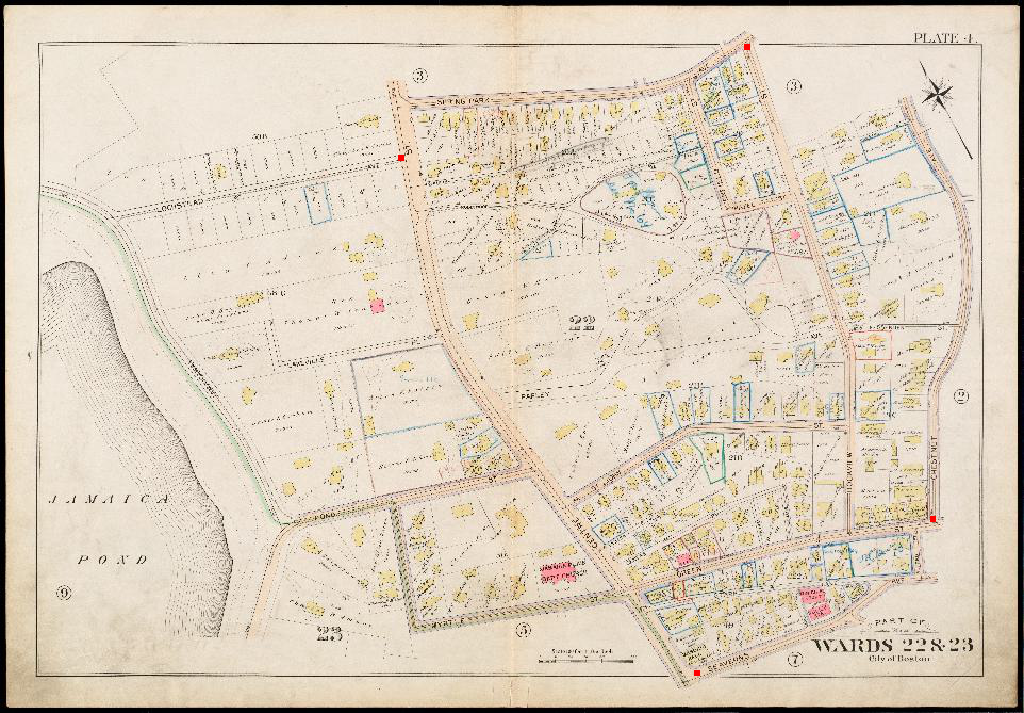

In [94]:
with ImageReader(image_path) as src:
    im = src.preview(max_size=1024)
    dx = im.width / src.dataset.width 
    dy = im.height / src.dataset.height 

    for pt in gcps:
        row = round(pt.row * dy)
        col = round(pt.col * dx)
        
        im.data[0, row - 3:row + 3, col - 3:col + 3] = 255
        im.data[1, row - 3:row + 3, col - 3:col + 3] = 0
        im.data[2, row - 3:row + 3, col - 3:col + 3] = 0

Image(im.render())

#### Use titiler.image GCPSReader

The `GCPSReader` is similar to the `rio_tiler.io.Reader` but it accepts 3 more arguments

- `gcps: List[GroundControlPoint]`: List of rasterio.control.GroundControlPoint

- `gcps_crs: CRS`: Rasterio CRS (set to WGS84 by default)

- `cutline: str`: WKT geometry cutline

bounds=BoundingBox(left=-71.12109003469376, bottom=42.31024457895685, right=-71.10602473306288, top=42.32079384410276) minzoom=14 maxzoom=20 band_metadata=[('b1', {}), ('b2', {}), ('b3', {}), ('b4', {})] band_descriptions=[('b1', ''), ('b2', ''), ('b3', ''), ('b4', '')] dtype='uint8' nodata_type='Alpha' colorinterp=['red', 'green', 'blue', 'alpha'] scale=None offset=None colormap=None count=4 width=12293 overviews=[2, 4, 8, 16] height=8608 driver='VRT'

(-71.12109003469376, 42.31024457895685, -71.10602473306288, 42.32079384410276)
EPSG:4326



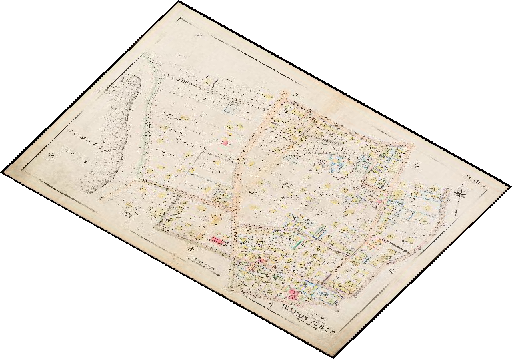

In [80]:
# Let's pass the GCPS from the GeoJSON to our non-geo file
with GCPSReader(image_path, gcps=gcps) as src:
    print(src.info())
    print()
    print(src.bounds)
    print(src.crs)
    print()
    im = src.preview(max_size=512)

Image(im.render())

ERROR 1: JPEGLib:Improper call to JPEG library in state 205
ERROR 1: JPEGSetupDecode:Bogus JPEGTables field


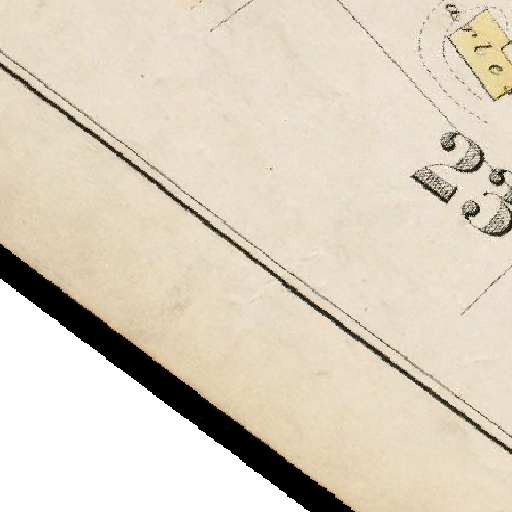

In [108]:
# Read a mercator tile
with GCPSReader(image_path, gcps=gcps) as src:
    im = src.tile(79285, 97003, 18, tilesize=512)

Image(im.render())

### The Cutline Option

GCPS are nice to georeference the data, but sometime you also want to crop the input image (e.g remove border of a map). For this you can use the `cutline` option. 

The `cutline` has to be Polygon or MultiPolygon geometry encoded as `WKT`.

Cutline in the image coordinates reference
POLYGON ((100 100, 7596 100, 7596 5252, 100 5252, 100 100))


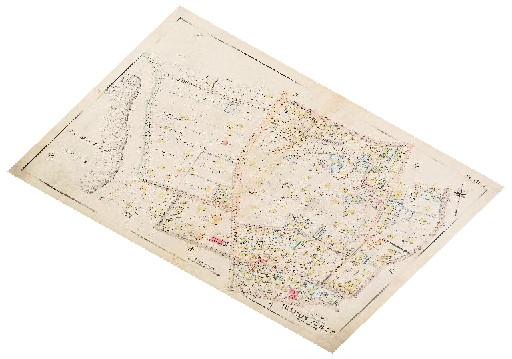

In [111]:
b = 100

with ImageReader(image_path) as src:
    w = src.dataset.width
    h = src.dataset.height

cutline = f"POLYGON (({b} {b}, {w - b} {b}, {w - b} {h - b}, {b} {h - b}, {b} {b}))"
print("Cutline in the image coordinates reference")
print(cutline)

# Let's pass the GCPS from the GeoJSON to our non-geo file
with GCPSReader(image_path, gcps=gcps, cutline=cutline) as src:
    im = src.preview(max_size=512)
    
Image(im.render())

ERROR 1: JPEGLib:Improper call to JPEG library in state 205
ERROR 1: JPEGSetupDecode:Bogus JPEGTables field


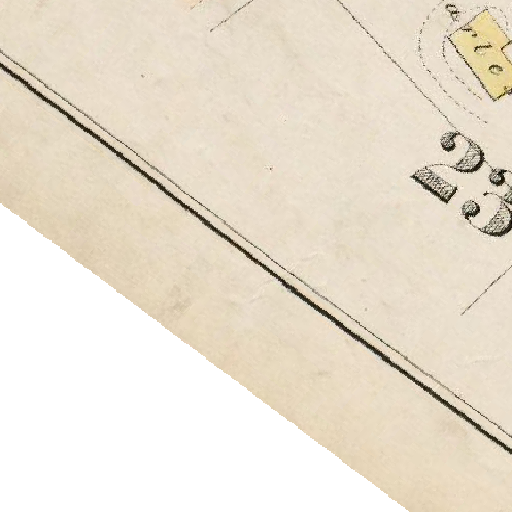

In [109]:
with GCPSReader(image_path, gcps=gcps, cutline=cutline) as src:
    im = src.tile(79285, 97003, 18, tilesize=512)

Image(im.render())